Kaggle Link: https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags

Abstract: Social tagging of movies reveals a wide range of heterogeneous information about movies, like the genre, plot structure, soundtracks, metadata, visual and emotional experiences. Such information can be valuable in building automatic systems to create tags for movies. Automatic tagging systems can help recommendation engines to improve the retrieval of similar movies as well as help viewers to know what to expect from a movie in advance. In this paper, we set out to the task of collecting a corpus of movie plot synopses and tags. We describe a methodology that enabled us to build a fine-grained set of around 70 tags exposing heterogeneous characteristics of movie plots and the multi-label associations of these tags with some 14K movie plot synopses. We investigate how these tags correlate with movies and the flow of emotions throughout different types of movies. Finally, we use this corpus to explore the feasibility of inferring tags from plot synopses. We expect the corpus will be useful in other tasks where analysis of narratives is relevant.

In [1]:
import warnings
warnings.filterwarnings("ignore")
# what is the probelem you are having?
# ok let me show

In [2]:
import pandas as pd
# import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [3]:
df = pd.read_csv(r'C:\Users\Cyborg\Documents\GitHub\Movie-Plot-Synopses\mpst_full_data.csv', delimiter=',')

In [4]:
nRow, nCol = df.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 14828 rows and 6 columns


In [5]:
df.head(5)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0057603,I tre volti della paura,Note: this synopsis is for the orginal Italian...,"cult, horror, gothic, murder, atmospheric",train,imdb
1,tt1733125,Dungeons & Dragons: The Book of Vile Darkness,"Two thousand years ago, Nhagruul the Foul, a s...",violence,train,imdb
2,tt0033045,The Shop Around the Corner,"Matuschek's, a gift store in Budapest, is the ...",romantic,test,imdb
3,tt0113862,Mr. Holland's Opus,"Glenn Holland, not a morning person by anyone'...","inspiring, romantic, stupid, feel-good",train,imdb
4,tt0086250,Scarface,"In May 1980, a Cuban man named Tony Montana (A...","cruelty, murder, dramatic, cult, violence, atm...",val,imdb


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14828 entries, 0 to 14827
Data columns (total 6 columns):
imdb_id            14828 non-null object
title              14828 non-null object
plot_synopsis      14828 non-null object
tags               14828 non-null object
split              14828 non-null object
synopsis_source    14828 non-null object
dtypes: object(6)
memory usage: 695.1+ KB


In [7]:
df["tag_count"] = df["tags"].apply(lambda text: len(text.split(" ")))

In [8]:
#Sorting data according to imdb_id in ascending order
sorted_data=df.sort_values('imdb_id', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [9]:
df=sorted_data.drop_duplicates(subset={"imdb_id","title","plot_synopsis"}, keep='first', inplace=False)
df.shape

(14828, 7)

In [10]:
df.head(4)

,imdb_id,title,plot_synopsis,tags,split,synopsis_source,tag_count
8814,tt0000091,Le manoir du diable,The film opens with a large bat flying into a ...,"paranormal, gothic",train,wikipedia,2
7085,tt0000225,La belle et la bête,A widower merchant lives in a mansion with his...,fantasy,train,wikipedia,1
11909,tt0000230,Cendrillon,"A prologue in front of the curtain, suppressed...",fantasy,train,wikipedia,1
548,tt0000417,Le voyage dans la lune,"At a meeting of the Astronomic Club, its presi...","psychedelic, satire",train,imdb,2


In [11]:
# distribution of number of tags per question
df.tag_count.value_counts()

1     5171
2     2997
3     1926
4     1318
5      960
6      661
7      492
8      374
9      252
10     191
11     136
12     100
13      70
14      44
15      35
16      31
17      21
18      18
20      11
19       8
21       3
26       2
27       2
22       2
23       2
24       1
Name: tag_count, dtype: int64

## Analysis of Tags

### Unique Tags

In [12]:
# Importing & Initializing the "CountVectorizer" object, which 
#is scikit-learn's bag of words tool.

#by default 'split()' will tokenize each tag using space.
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=False)
# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of strings.
tag_dtm = vectorizer.fit_transform(df['tags'])

In [13]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 14828
Number of unique tags : 147


In [14]:
#'get_feature_name()' gives us the vocabulary.
tags = vectorizer.get_feature_names()
#Lets look at the tags we have.
print("Some of the tags we have :", tags[0:10])

Some of the tags we have : ['absurd', 'absurd,', 'action', 'action,', 'adult', 'allegory', 'allegory,', 'alternate', 'anti', 'atmospheric']


### Number of times a tag appeared 

In [15]:
# https://stackoverflow.com/questions/15115765/how-to-access-sparse-matrix-elements
#Lets now store the document term matrix in a dictionary.
freqs = tag_dtm.sum(axis=0).A1
result = dict(zip(tags, freqs))

In [16]:
#Saving this dictionary to csv files.
if not os.path.isfile('tag_counts_dict_dtm.csv'):
    with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
        writer = csv.writer(csv_file)
        for key, value in result.items():
            writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,absurd,11
1,"absurd,",259
2,action,111
3,"action,",553
4,adult,128


In [17]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

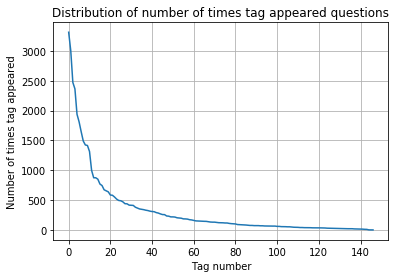

In [18]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

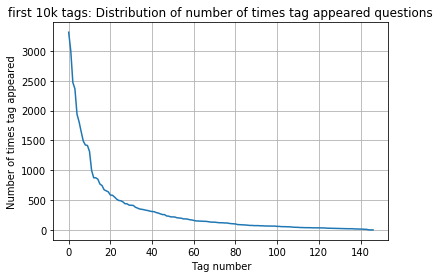

6 [3311  490  220  118   61   30]


In [19]:
plt.plot(tag_counts[0:10000])
plt.title('first 10k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:10000:25]), tag_counts[0:10000:25])

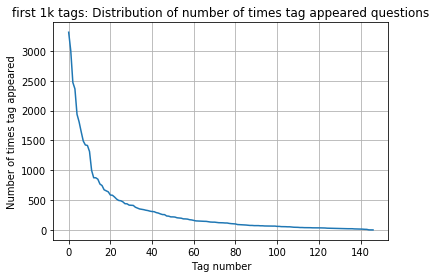

30 [3311 1811 1315  770  586  490  415  347  310  259  220  187  161  146
  132  118  102   84   74   68   61   54   45   40   36   30   24   22
   17    2]


In [20]:
plt.plot(tag_counts[0:1000])
plt.title('first 1k tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()
print(len(tag_counts[0:1000:5]), tag_counts[0:1000:5])

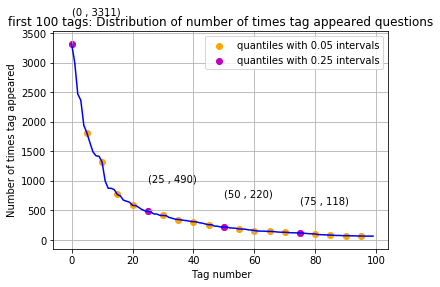

20 [3311 1811 1315  770  586  490  415  347  310  259  220  187  161  146
  132  118  102   84   74   68]


In [21]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

## Tags per movie

In [22]:
#Storing the count of tag in each question in list 'tag_count'
tag_quest_count = tag_dtm.sum(axis=1).tolist()
#Converting list of lists into single list, we will get [[3], [4], [2], [2], [3]] and we are converting this to [3, 4, 2, 2, 3]
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 14828 datapoints.
[2, 1, 1, 2, 2]


In [23]:
print( "Maximum number of tags per movie: %d"%max(tag_quest_count))
print( "Minimum number of tags per movie: %d"%min(tag_quest_count))
print( "Avg. number of tags per movie: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per movie: 27
Minimum number of tags per movie: 1
Avg. number of tags per movie: 3.248854


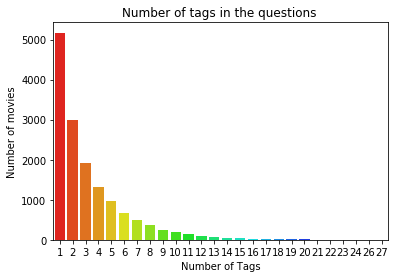

In [24]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of movies")
plt.show()

### Most frequent tags

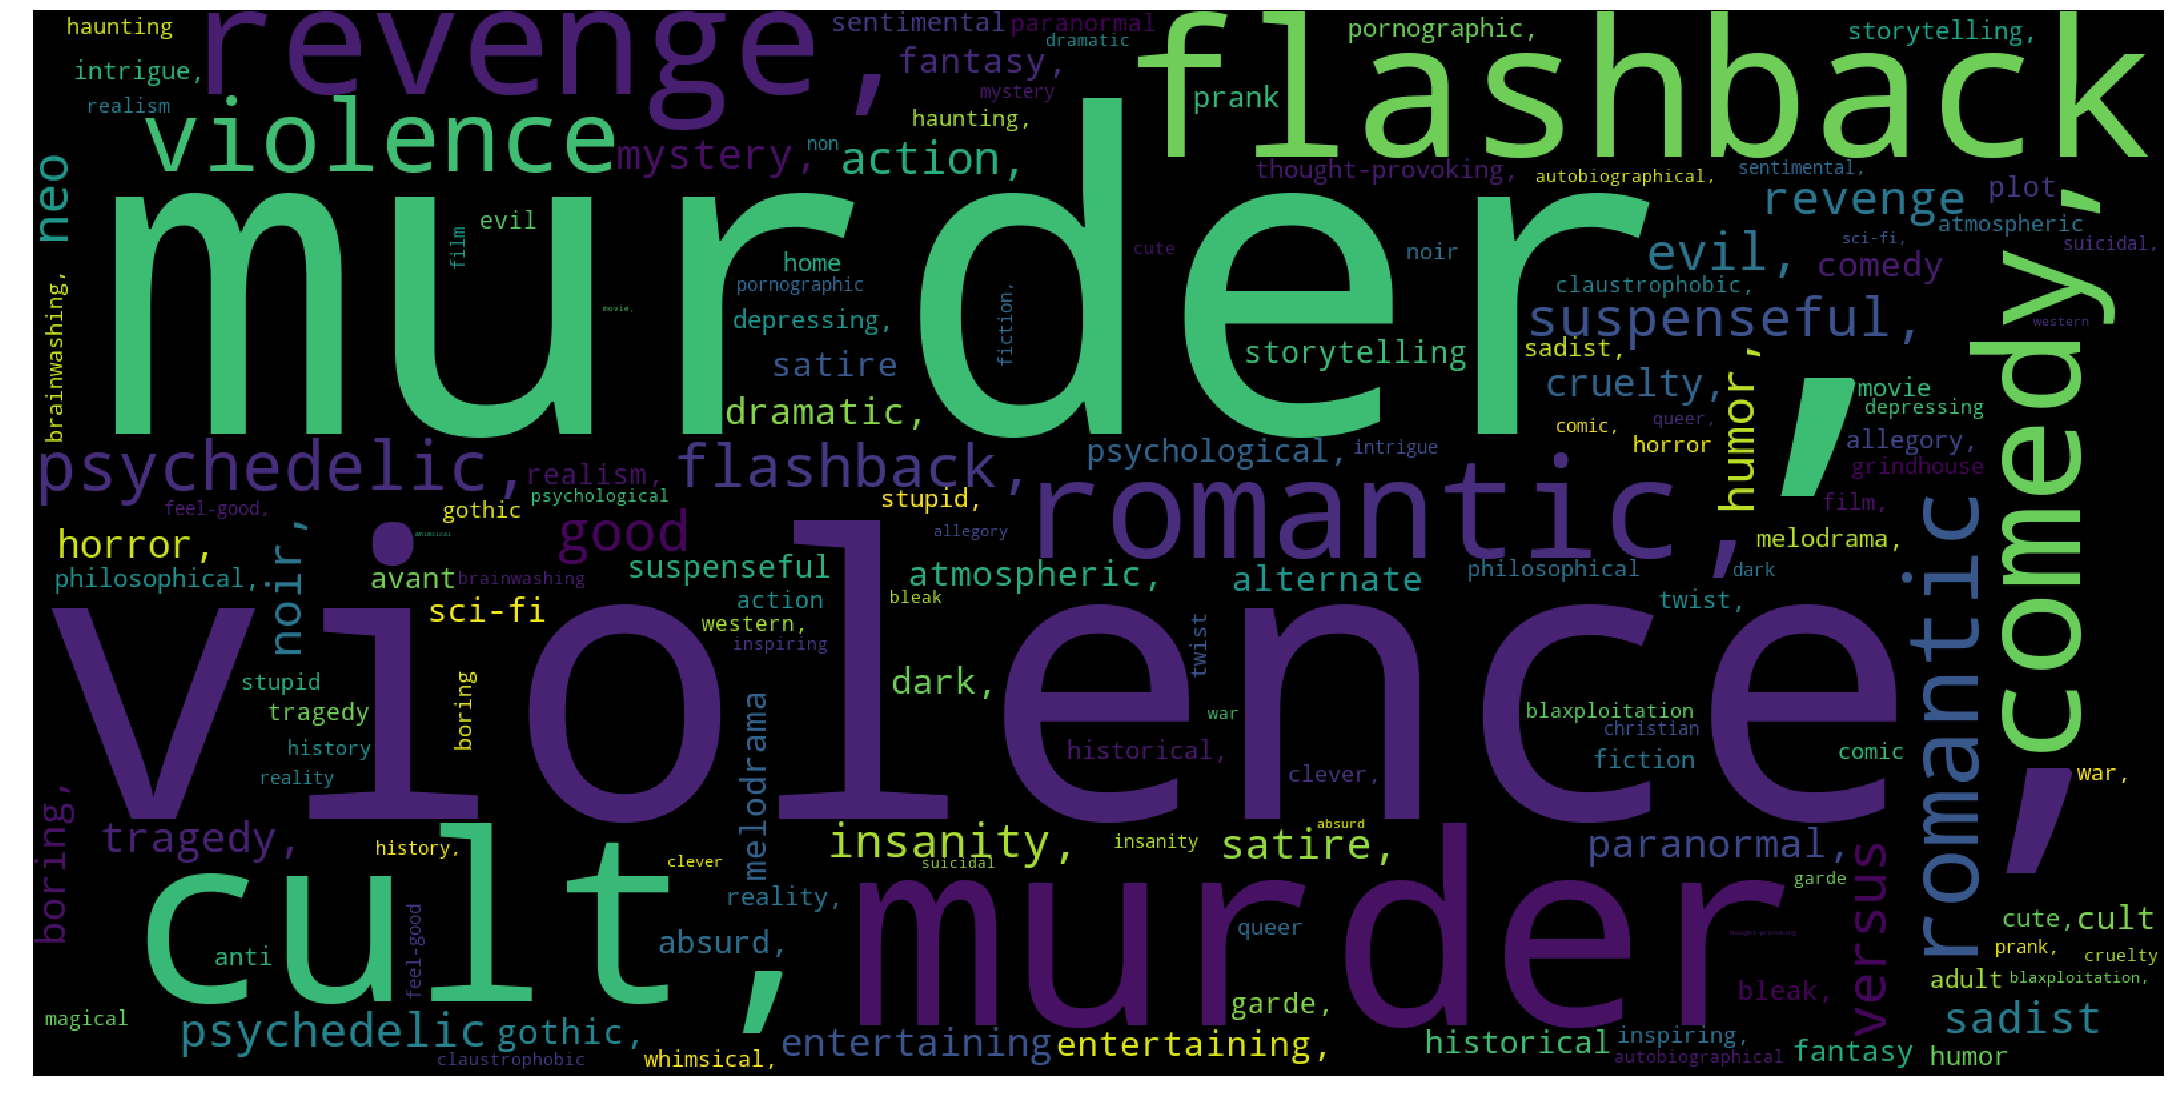

Time taken to run this cell : 0:00:07.668143


In [25]:
# Ploting word cloud
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)



### Top 20 Tags

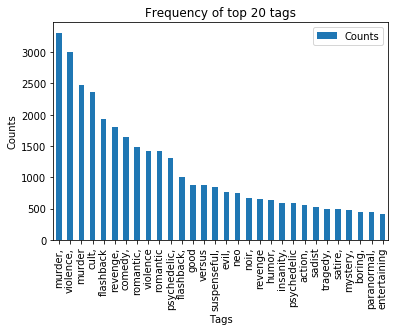

In [26]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()



## Cleaning and Pre-Processing

In [27]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

In [28]:
from tqdm import tqdm


In [29]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [30]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [31]:
df.columns

Index(['imdb_id', 'title', 'plot_synopsis', 'tags', 'split', 'synopsis_source',
       'tag_count'],
      dtype='object')

In [32]:
preprocessed_synopsis = []
# tqdm is for printing the status bar
for sentance in tqdm(df['plot_synopsis'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_synopsis.append(sentance.strip())

100%|███████████████████████████████████████████████████████████████████████████| 14828/14828 [00:58<00:00, 252.39it/s]


In [33]:
len(df['tags'])

14828

In [34]:
# import numpy as np
# df=np.hstack((preprocessed_synopsis,df['tags'])) 


In [35]:
# I have done all the cleaning and all
# I am having problem modelling
# I tried doing it as per stackoverflow case study, but isn't working that way
# stackoverflow is opened in parallel tab for reference
# what you mean by not working?

In [36]:
 df1 = pd.DataFrame()

In [37]:
df1.head(3)

""


In [38]:
df['tags'][0]

'cult, horror, gothic, murder, atmospheric'

In [39]:
preprocessed_synopsis[10]

'two men friends john jim compete hand mary start journey westward mary betrothed john soon finds lush behaviors native americans ambush train attack leaves party low supply water fearing dehydration need john jim set water jim gives water older gentleman john gives jim last drop water thus sacrificing train continue westward jim finds water supply energy john gave last drop water train rescued troops publicity preproduction last drop water promoted extras well show detail money going western biograph company heavily promoting film one highest state production within film industry day trying prove modernity state change within film industry considered griffith way continuing career since western time losing popularity late break western genre title film changed wagon train going westward changed prior film release date california variety environments used within film starting become popular filmmakers access natural various landscapes themes whole film allusion life sir philip sydney m

### Converting tags for multilabel problems 

In [40]:
# preprocessed_data=df1
# this was just mistake ignore

In [41]:
# print("number of data points in sample :", preprocessed_synopsis.shape[0])
# print("number of dimensions :", preprocessed_synopsis.shape[1])

In [42]:
# preprocessed_data there is nothinging in this?
# I know. I was trying ways taking help from stakoverflow.com
# Some variable names are from there, which I forgot to delete
# you don't need to excatly do what we have done in the SO
# you think of logic whichcan work with this data
#  Actually I have preprocessed and cleaned data. Just help me with modelling
# where is your y values stored?
# can i just clean the mess. I was trying something, so have a little mess now. Y values are down below

In [43]:
# binary='true' will give a binary vectorizer
# vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary=None)
vectorizer = CountVectorizer()
# ths is correct only
# but once you have it done, we need to check the contents of the multilabel_y
multilabel_y = vectorizer.fit_transform(df['tags'])

In [54]:
vectorizer.get_feature_names()

['absurd',
 'action',
 'adult',
 'allegory',
 'alternate',
 'anti',
 'atmospheric',
 'autobiographical',
 'avant',
 'blaxploitation',
 'bleak',
 'boring',
 'brainwashing',
 'christian',
 'claustrophobic',
 'clever',
 'comedy',
 'comic',
 'cruelty',
 'cult',
 'cute',
 'dark',
 'depressing',
 'dramatic',
 'entertaining',
 'evil',
 'fantasy',
 'feel',
 'fi',
 'fiction',
 'film',
 'flashback',
 'garde',
 'good',
 'gothic',
 'grindhouse',
 'haunting',
 'historical',
 'history',
 'home',
 'horror',
 'humor',
 'insanity',
 'inspiring',
 'intrigue',
 'magical',
 'melodrama',
 'movie',
 'murder',
 'mystery',
 'neo',
 'noir',
 'non',
 'paranormal',
 'philosophical',
 'plot',
 'pornographic',
 'prank',
 'provoking',
 'psychedelic',
 'psychological',
 'queer',
 'realism',
 'reality',
 'revenge',
 'romantic',
 'sadist',
 'satire',
 'sci',
 'sentimental',
 'storytelling',
 'stupid',
 'suicidal',
 'suspenseful',
 'thought',
 'tragedy',
 'twist',
 'versus',
 'violence',
 'war',
 'western',
 'whimsical

In [44]:
Y = multilabel_y.toarray()
# you don;t need to add them to a dataframe let them be separate
X = preprocessed_synopsis

In [45]:
# now you can work like your AFR assignmnet
# print(X.shape)
# print(Y.shape)
# preprocessed_data['tags'][0]

### Preparing data

In [46]:
# df1['synopsis']=preprocessed_synopsis
# df1['tags']=multilabel_y.toarray() # you can't store sparse matrix

### Split Data

In [47]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [48]:
print("shape of train : ", len(X_train),",", y_train.shape)
print("Shape of Test : ",len(X_test),",", y_test.shape)

shape of train :  10379 , (10379, 82)
Shape of Test :  4449 , (4449, 82)


In [49]:
# total_size=len(preprocessed_synopsis)
# train_size=int(0.70*total_size)

# X_train=preprocessed_synopsis.head(train_size)
# X_test=preprocessed_data.tail(total_size - train_size)


# y_train = Y[0:train_size,:]
# y_test = Y[train_size:total_size,:]

### Vectorizing Data

In [50]:
from sklearn.feature_extraction.text import TfidfVectorizer
start = datetime.now()
# tfidf = TfidfVectorizer()
tfidf=CountVectorizer(min_df=0.00009,    \
                              ngram_range=(1,4))
x_train_tfidf=tfidf.fit_transform(X_train)
x_test_tfidf=tfidf.transform(X_test)
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:03:10.314891


In [51]:
# total_size=preprocessed_data.shape[0]
# train_size=int(0.70*total_size)

# x_train=preprocessed_data.head(X)
# x_test=preprocessed_data.tail(total_size - train_size)


# y_train = Y[0:train_size,:]
# y_test = Y[train_size:total_size,:]

In [52]:
print("Number of data points in  train data :",x_train_tfidf.shape,y_train.shape)
print("Number of data points in  test data :",x_test_tfidf.shape, y_test.shape)

Number of data points in  train data : (10379, 13061179) (10379, 82)
Number of data points in  test data : (4449, 13061179) (4449, 82)


### Applying Logistic Regression with OneVsRest Classifier 

In [53]:
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_tfidf, y_train)
predictions = classifier.predict(x_test_tfidf)

print("accuracy :",metrics.accuracy_score(y_test,predictions))
print("macro f1 score :",metrics.f1_score(y_test, predictions, average = 'macro'))
print("micro f1 scoore :",metrics.f1_score(y_test, predictions, average = 'micro'))
print("hamming loss :",metrics.hamming_loss(y_test,predictions))
print("Precision recall report :\n",metrics.classification_report(y_test, predictions))

ValueError: Multioutput target data is not supported with label binarization

In [ ]:
#  how about the above snippet
# or shall I go with normal modelling. Because this is a multi-label classification problem
# yes you have to use the above method only
# ok. what would be a good metric score >0.7
# ok. thanks
#can i disconnect now- yes